In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
#importing required libraries
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import TextBlob
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import rcParams
from sklearn.decomposition import PCA
import seaborn as sns


import gensim
import gensim.downloader as api

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#reading the dataset
df = pd.read_csv('/content/drive/MyDrive/DA/data/combined_dataset.csv')

In [ ]:
df.head()

In [ ]:
#number of instances in the dataset
len(df)

In [ ]:
#number of features in the dataset
len(df.columns)

In [ ]:
#checking if there are any null values in the dataset
df.isnull().sum()

In [ ]:
#checking for duplicated rows in the dataset
df.duplicated().sum()

In [ ]:
#removing duplicates
df = df.drop_duplicates()
df.duplicated().sum()

In [ ]:
df['subject'].value_counts()

In [ ]:
#checking for inconsistent values
lst = []

for i in df['date']:
  i = i[-5:]
  i = i.strip()
  lst.append(i)

df['year'] = lst
df['year'].value_counts()

In [ ]:
#removing inconsistent values
df = df[df.year!="eb-18"]
df = df[df.year!="d.jpg"]
df = df[df.year!="t.jpg"]
df = df[df.year!="ideo]"]
df = df[df.year!="dier/"]
df = df[df.year!="left/"]
df = df[df.year!="-pie/"]
df['year'].value_counts()

2017    25711
2016    16455
2015     2478
Name: year, dtype: int64

In [ ]:
#cleaning the categorical features
def cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['title'] = df['title'].apply(lambda x:cleaning(x))
df['text'] = df['text'].apply(lambda x:cleaning(x))

In [ ]:
#removing stopwords
stop = stopwords.words('english')
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
df['label'].value_counts()

0    23433
1    21211
Name: label, dtype: int64

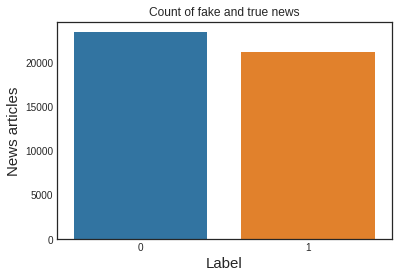

In [ ]:
#Count of fake and true news
ax = sns.countplot(x = "label", data = df)

#Setting labels and font size
ax.set(xlabel = 'Label', ylabel = 'News articles', title = 'Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

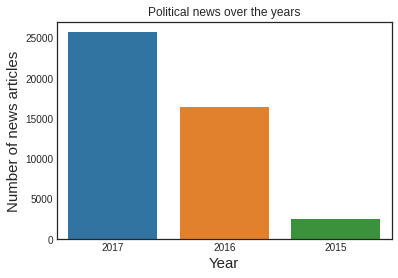

In [ ]:
#Political news over the years
ax = sns.countplot(x = "year", data = df)

#Setting labels and font size
ax.set(xlabel = 'Year', ylabel = 'Number of news articles', title = 'Political news over the years')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

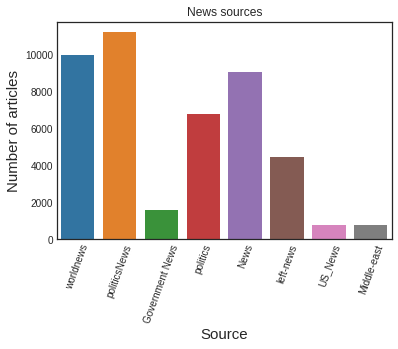

In [ ]:
#Sources of news
ax = sns.countplot(x = "subject", data = df)

#Setting labels and font size
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10, rotation = 70)
ax.set(xlabel = 'Source', ylabel = 'Number of articles', title = 'News sources')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

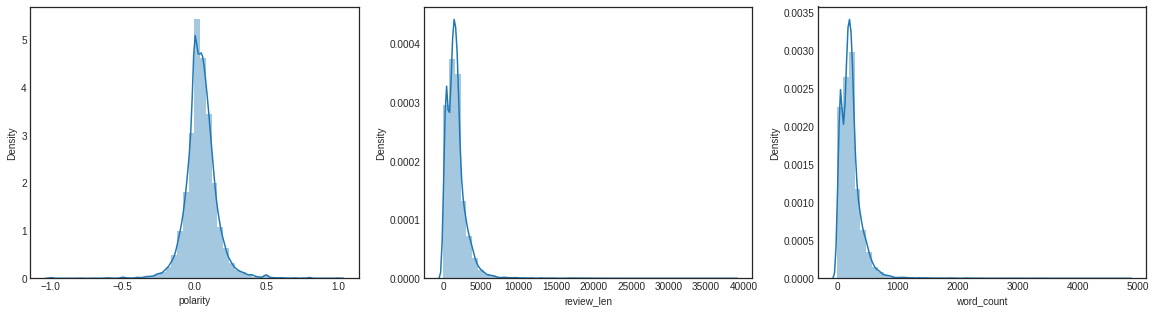

In [ ]:
#Extracting the features from text
df['polarity'] = df['text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(df['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(df['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(df['word_count'])
fig = plt.gcf()

In [ ]:
#top n words in the dataset
def get_top_n_words(corpus, n = None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

common_words = get_top_n_words(df['text'], 20)
for word, freq in common_words:
    print(word, freq)

said 128820
trump 126876
us 62608
would 54547
president 51595
people 40932
one 35396
state 32005
also 30959
new 30713
reuters 28465
donald 27452
clinton 27310
house 26924
obama 26836
government 26589
states 25830
republican 24223
could 23712
united 23289


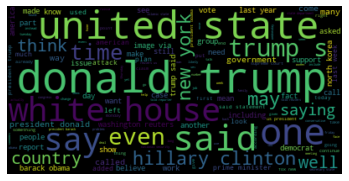

In [ ]:
#word cloud for the entire dataset
text = " ".join(x for x in df.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color = 'black').generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [ ]:
#word embeddings using Glove
glove_gensim  = api.load('glove-wiki-gigaword-300')
vocab = glove_gensim.wv.vocab

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#extracting maximum token length
maxi=-1
for i,rev in enumerate(df['text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)
maxi

4818

In [ ]:
#tokenizing the news article
tokenizer = Tokenizer()
df_total = df['text']
tokenizer.fit_on_texts(df_total)

In [ ]:
max_rev_len = maxi  
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 300

In [ ]:
#padding the tokinized news articles
X_train = tokenizer.texts_to_sequences(df['text'])  
X_train_pad = pad_sequences(X_train, maxlen = max_rev_len, padding = 'post') 

In [ ]:
vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = glove_gensim.wv.get_vector(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [ ]:
#extracting embedding matrix
embed_matrix = np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  
    embed_matrix[i] = embed_vector

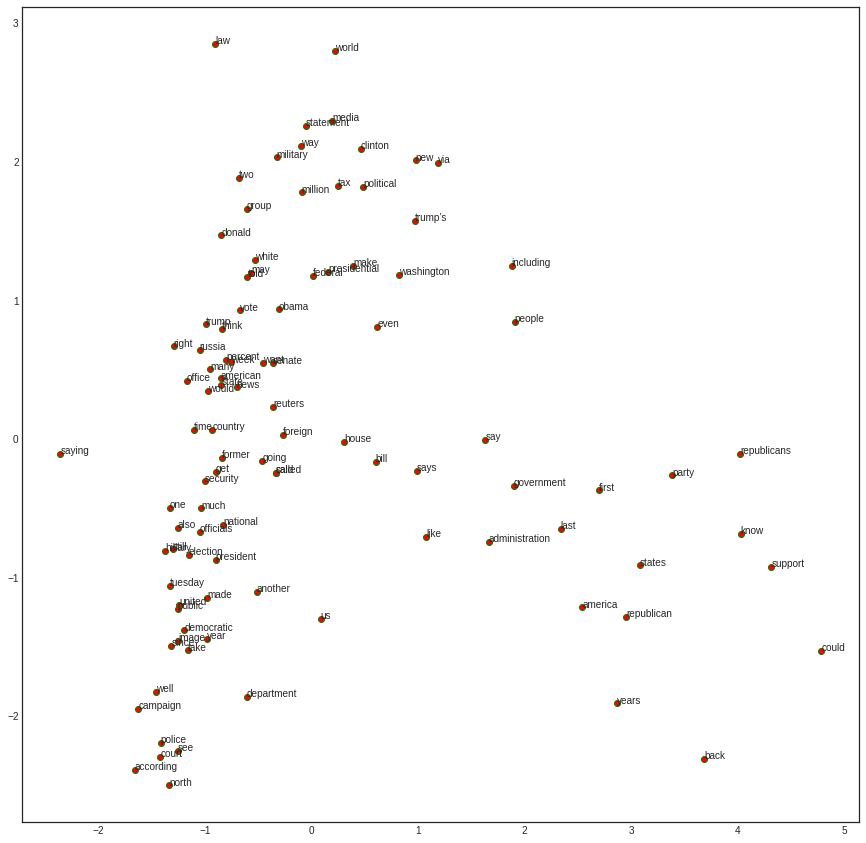

In [ ]:
#PCA for visualization of word embeddings
lst = []
for i in tokenizer.word_index.keys():
  lst.append(i)
pca = PCA(n_components = 2)
np.set_printoptions(suppress = True)
P = pca.fit_transform(embed_matrix[:100])
labels = lst
plt.figure(figsize = (15, 15))
plt.scatter(P[:, 0], P[:, 1], c = 'r', edgecolors = 'g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x, y), xytext = (0, 0), textcoords = 'offset points', )